In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from scipy.stats import beta
from snowflake import connector
import pandas as pd
import os
from dotenv import load_dotenv

from tabulate import tabulate
import openai
import warnings

warnings.filterwarnings('ignore', category=Warning)

In [2]:
load_dotenv('/Users/peter/.env')

# establish Snowflake connection
connection = connector.connect(user=os.getenv("SNOWFLAKE_USERNAME"), 
                  password=os.getenv("SNOWFLAKE_PASSWORD"), 
                  account=os.getenv("SNOWFLAKE_ACCOUNT"), 
                  role=os.getenv("SNOWFLAKE_ROLE"), 
                  warehouse=os.getenv("SNOWFLAKE_WAREHOUSE"),
                  database = 'DISCO_CORE' 
                  )

# Set OpenAI API key
openai.api_key = os.getenv("OPENAI_API_KEY")

### Query

In [3]:
brand_value_query = """
WITH csm_primary_category AS (select cb.name,
                au.first_name,
                au.last_name,
                cc.name as "Primary Category"
        from postgres.core_publisher cp
          left join postgres.accounts_user au on cp.account_representative_id = au.accounts_user_id
          left join postgres.core_brand cb on  cp.brand_id = cb.core_brand_id
          left join postgres.core_category cc on cb.primary_category_id = cc.core_category_id
        )
  ,  merchant_ids AS (select cb.name as merchant_name,
                cb.core_brand_id as brand_id,
                cp.remote_id as publisher_remote_id,
                cp.core_publisher_id as publisher_id,
                cp.widget_live_date as widget_live_date,
                min(ldp.date) as first_dfl_date
      from postgres.core_brand as cb
        inner join postgres.core_publisher as cp on cp.brand_id = cb.core_brand_id
        left join disco_mixpanel.loads_displays_performance as ldp on ldp.merchant = cb.name and widget_loads_d > 0

      group by 1, 2, 3, 4, 5
            )
  ,  bod_individual_conversions_overdelivery AS (select bodod.*,
                mc.driving_brand,
                mc.order_cost as order_revenue,
                mc.customer_type,
                mc.time_delta_days,
                mc.most_recent_purchase_publisher
         from disco_mixpanel.bod_individual_conversions_overdelivery as bodod
            left join disco_mixpanel.master_conversions as mc on bodod.conversion_unique_key = mc.unique_key )
SELECT
    merchant_ids.publisher_remote_id  AS "merchant_ids.publisher_remote_id",
    case when loads_displays_performance.merchant = 'Péla Case' then 'Pela Case'
              when loads_displays_performance.merchant = '120/Life Beverage' then '120/Life'
              when loads_displays_performance.merchant = 'BAZZAAL BOX' then 'BAZZAAL INC'
              when loads_displays_performance.merchant = 'California Arts & Recreation Board' then 'California Arts'
              when loads_displays_performance.merchant = 'CanDo (makers of Keto Krisp)' then 'CanDo'
              when loads_displays_performance.merchant = 'CanDo (makes of Keto Krisp)' then 'CanDo'
              when loads_displays_performance.merchant = 'Irecovr' then 'iRecovr'
              when loads_displays_performance.merchant = 'Laura Geller Beauty' then 'Laura Geller'
              when loads_displays_performance.merchant = 'Pet Memory Shop' then 'Pet Memory'
              when loads_displays_performance.merchant = 'The Crunch Cup' then 'The CrunchCup'
              when loads_displays_performance.merchant = 'Tippsy, Inc' then 'Tippsy Sake'
              when loads_displays_performance.merchant = 'WHY AND WHALE' then 'Why and Whale'
              else loads_displays_performance.merchant
              end  AS "loads_displays_performance.merchant",
    csm_primary_category."Primary Category"  AS "csm_primary_category.primary_category",
    COALESCE(CAST( ( SUM(DISTINCT (CAST(FLOOR(COALESCE( bod_individual_conversions_overdelivery.bod_spend  ,0)*(1000000*1.0)) AS DECIMAL(38,0))) + (TO_NUMBER(MD5( bod_individual_conversions_overdelivery.conversion_unique_key  ), 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX') % 1.0e27)::NUMERIC(38, 0) ) - SUM(DISTINCT (TO_NUMBER(MD5( bod_individual_conversions_overdelivery.conversion_unique_key  ), 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX') % 1.0e27)::NUMERIC(38, 0)) )  AS DOUBLE PRECISION) / CAST((1000000*1.0) AS DOUBLE PRECISION), 0) AS "bod_individual_conversions_overdelivery.total_bod_spend",
    COALESCE(CAST( ( SUM(DISTINCT (CAST(FLOOR(COALESCE( bod_individual_conversions_overdelivery_publisher.bod_spend  ,0)*(1000000*1.0)) AS DECIMAL(38,0))) + (TO_NUMBER(MD5( bod_individual_conversions_overdelivery_publisher.conversion_unique_key  ), 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX') % 1.0e27)::NUMERIC(38, 0) ) - SUM(DISTINCT (TO_NUMBER(MD5( bod_individual_conversions_overdelivery_publisher.conversion_unique_key  ), 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX') % 1.0e27)::NUMERIC(38, 0)) )  AS DOUBLE PRECISION) / CAST((1000000*1.0) AS DOUBLE PRECISION), 0) AS "bod_individual_conversions_overdelivery_publisher.total_bod_spend",
    COALESCE(CAST( ( SUM(DISTINCT (CAST(FLOOR(COALESCE( loads_displays_performance.widget_loads_d  ,0)*(1000000*1.0)) AS DECIMAL(38,0))) + (TO_NUMBER(MD5( loads_displays_performance.merchant || loads_displays_performance.date  ), 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX') % 1.0e27)::NUMERIC(38, 0) ) - SUM(DISTINCT (TO_NUMBER(MD5( loads_displays_performance.merchant || loads_displays_performance.date  ), 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX') % 1.0e27)::NUMERIC(38, 0)) )  AS DOUBLE PRECISION) / CAST((1000000*1.0) AS DOUBLE PRECISION), 0) AS "loads_displays_performance.widget_loads",
    COALESCE(CAST( ( SUM(DISTINCT (CAST(FLOOR(COALESCE( loads_displays_performance.cross_sell_widget_brand_displays_d  ,0)*(1000000*1.0)) AS DECIMAL(38,0))) + (TO_NUMBER(MD5( loads_displays_performance.merchant || loads_displays_performance.date  ), 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX') % 1.0e27)::NUMERIC(38, 0) ) - SUM(DISTINCT (TO_NUMBER(MD5( loads_displays_performance.merchant || loads_displays_performance.date  ), 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX') % 1.0e27)::NUMERIC(38, 0)) )  AS DOUBLE PRECISION) / CAST((1000000*1.0) AS DOUBLE PRECISION), 0) AS "loads_displays_performance.cross_sell_widget_brand_displays",
    COALESCE(CAST( ( SUM(DISTINCT (CAST(FLOOR(COALESCE( new_merchant_gmv.gmv  ,0)*(1000000*1.0)) AS DECIMAL(38,0))) + (TO_NUMBER(MD5( concat( new_merchant_gmv.merchant  , ( (TO_CHAR(TO_DATE(new_merchant_gmv.date ), 'YYYY-MM-DD')) ))  ), 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX') % 1.0e27)::NUMERIC(38, 0) ) - SUM(DISTINCT (TO_NUMBER(MD5( concat( new_merchant_gmv.merchant  , ( (TO_CHAR(TO_DATE(new_merchant_gmv.date ), 'YYYY-MM-DD')) ))  ), 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX') % 1.0e27)::NUMERIC(38, 0)) )  AS DOUBLE PRECISION) / CAST((1000000*1.0) AS DOUBLE PRECISION), 0) AS "new_merchant_gmv.total_gmv",
    COALESCE(CAST( ( SUM(DISTINCT (CAST(FLOOR(COALESCE( ( cast( case when left(regexp_replace(bod_individual_conversions_overdelivery.order_revenue,'([^0-9.])',''), 1) = '.' then substring(regexp_replace(bod_individual_conversions_overdelivery.order_revenue,'([^0-9.])',''), 2, 20)
                    when regexp_replace(bod_individual_conversions_overdelivery.order_revenue,'([^0-9.])','') is null then '0.00'
                    when regexp_replace(bod_individual_conversions_overdelivery.order_revenue,'([^0-9.])','') = '' then '0.00'
                    else regexp_replace(bod_individual_conversions_overdelivery.order_revenue,'([^0-9.])','')
                    end as float)  ) * ( case when bod_individual_conversions_overdelivery.bod_spend > 0 then 1
              else 0
              end) ,0)*(1000000*1.0)) AS DECIMAL(38,0))) + (TO_NUMBER(MD5( bod_individual_conversions_overdelivery.conversion_unique_key  ), 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX') % 1.0e27)::NUMERIC(38, 0) ) - SUM(DISTINCT (TO_NUMBER(MD5( bod_individual_conversions_overdelivery.conversion_unique_key  ), 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX') % 1.0e27)::NUMERIC(38, 0)) )  AS DOUBLE PRECISION) / CAST((1000000*1.0) AS DOUBLE PRECISION), 0) AS "bod_individual_conversions_overdelivery.total_brand_revenue_billable",
    COALESCE(CAST( ( SUM(DISTINCT (CAST(FLOOR(COALESCE( ( case when bod_individual_conversions_overdelivery.bod_spend > 0 then 1
              else 0
              end )  ,0)*(1000000*1.0)) AS DECIMAL(38,0))) + (TO_NUMBER(MD5( bod_individual_conversions_overdelivery.conversion_unique_key  ), 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX') % 1.0e27)::NUMERIC(38, 0) ) - SUM(DISTINCT (TO_NUMBER(MD5( bod_individual_conversions_overdelivery.conversion_unique_key  ), 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX') % 1.0e27)::NUMERIC(38, 0)) )  AS DOUBLE PRECISION) / CAST((1000000*1.0) AS DOUBLE PRECISION), 0) AS "bod_individual_conversions_overdelivery.total_quantity_billable",
    COALESCE(CAST( ( SUM(DISTINCT (CAST(FLOOR(COALESCE( ( cast( case when left(regexp_replace(bod_individual_conversions_overdelivery_publisher.order_revenue,'([^0-9.])',''), 1) = '.' then substring(regexp_replace(bod_individual_conversions_overdelivery_publisher.order_revenue,'([^0-9.])',''), 2, 20)
                    when regexp_replace(bod_individual_conversions_overdelivery_publisher.order_revenue,'([^0-9.])','') is null then '0.00'
                    when regexp_replace(bod_individual_conversions_overdelivery_publisher.order_revenue,'([^0-9.])','') = '' then '0.00'
                    else regexp_replace(bod_individual_conversions_overdelivery_publisher.order_revenue,'([^0-9.])','')
                    end as float)  ) * ( case when bod_individual_conversions_overdelivery_publisher.bod_spend > 0 then 1
              else 0
              end) ,0)*(1000000*1.0)) AS DECIMAL(38,0))) + (TO_NUMBER(MD5( bod_individual_conversions_overdelivery_publisher.conversion_unique_key  ), 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX') % 1.0e27)::NUMERIC(38, 0) ) - SUM(DISTINCT (TO_NUMBER(MD5( bod_individual_conversions_overdelivery_publisher.conversion_unique_key  ), 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX') % 1.0e27)::NUMERIC(38, 0)) )  AS DOUBLE PRECISION) / CAST((1000000*1.0) AS DOUBLE PRECISION), 0) AS "bod_individual_conversions_overdelivery_publisher.total_brand_revenue_billable",
    COALESCE(CAST( ( SUM(DISTINCT (CAST(FLOOR(COALESCE( ( case when bod_individual_conversions_overdelivery_publisher.bod_spend > 0 then 1
              else 0
              end )  ,0)*(1000000*1.0)) AS DECIMAL(38,0))) + (TO_NUMBER(MD5( bod_individual_conversions_overdelivery_publisher.conversion_unique_key  ), 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX') % 1.0e27)::NUMERIC(38, 0) ) - SUM(DISTINCT (TO_NUMBER(MD5( bod_individual_conversions_overdelivery_publisher.conversion_unique_key  ), 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX') % 1.0e27)::NUMERIC(38, 0)) )  AS DOUBLE PRECISION) / CAST((1000000*1.0) AS DOUBLE PRECISION), 0) AS "bod_individual_conversions_overdelivery_publisher.total_quantity_billable",
    COALESCE(CAST( ( SUM(DISTINCT (CAST(FLOOR(COALESCE( new_merchant_gmv.order_count  ,0)*(1000000*1.0)) AS DECIMAL(38,0))) + (TO_NUMBER(MD5( concat( new_merchant_gmv.merchant  , ( (TO_CHAR(TO_DATE(new_merchant_gmv.date ), 'YYYY-MM-DD')) ))  ), 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX') % 1.0e27)::NUMERIC(38, 0) ) - SUM(DISTINCT (TO_NUMBER(MD5( concat( new_merchant_gmv.merchant  , ( (TO_CHAR(TO_DATE(new_merchant_gmv.date ), 'YYYY-MM-DD')) ))  ), 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX') % 1.0e27)::NUMERIC(38, 0)) )  AS DOUBLE PRECISION) / CAST((1000000*1.0) AS DOUBLE PRECISION), 0) AS "new_merchant_gmv.total_orders"
FROM disco_mixpanel.loads_displays_performance  AS loads_displays_performance
LEFT JOIN disco_mixpanel.new_merchant_gmv  AS new_merchant_gmv ON (case when loads_displays_performance.merchant = 'Péla Case' then 'Pela Case'
              when loads_displays_performance.merchant = '120/Life Beverage' then '120/Life'
              when loads_displays_performance.merchant = 'BAZZAAL BOX' then 'BAZZAAL INC'
              when loads_displays_performance.merchant = 'California Arts & Recreation Board' then 'California Arts'
              when loads_displays_performance.merchant = 'CanDo (makers of Keto Krisp)' then 'CanDo'
              when loads_displays_performance.merchant = 'CanDo (makes of Keto Krisp)' then 'CanDo'
              when loads_displays_performance.merchant = 'Irecovr' then 'iRecovr'
              when loads_displays_performance.merchant = 'Laura Geller Beauty' then 'Laura Geller'
              when loads_displays_performance.merchant = 'Pet Memory Shop' then 'Pet Memory'
              when loads_displays_performance.merchant = 'The Crunch Cup' then 'The CrunchCup'
              when loads_displays_performance.merchant = 'Tippsy, Inc' then 'Tippsy Sake'
              when loads_displays_performance.merchant = 'WHY AND WHALE' then 'Why and Whale'
              else loads_displays_performance.merchant
              end) = new_merchant_gmv.merchant and
      (TO_CHAR(TO_DATE(loads_displays_performance.date ), 'YYYY-MM-DD')) = (TO_CHAR(TO_DATE(new_merchant_gmv.date ), 'YYYY-MM-DD'))
LEFT JOIN csm_primary_category ON (case when loads_displays_performance.merchant = 'Péla Case' then 'Pela Case'
              when loads_displays_performance.merchant = '120/Life Beverage' then '120/Life'
              when loads_displays_performance.merchant = 'BAZZAAL BOX' then 'BAZZAAL INC'
              when loads_displays_performance.merchant = 'California Arts & Recreation Board' then 'California Arts'
              when loads_displays_performance.merchant = 'CanDo (makers of Keto Krisp)' then 'CanDo'
              when loads_displays_performance.merchant = 'CanDo (makes of Keto Krisp)' then 'CanDo'
              when loads_displays_performance.merchant = 'Irecovr' then 'iRecovr'
              when loads_displays_performance.merchant = 'Laura Geller Beauty' then 'Laura Geller'
              when loads_displays_performance.merchant = 'Pet Memory Shop' then 'Pet Memory'
              when loads_displays_performance.merchant = 'The Crunch Cup' then 'The CrunchCup'
              when loads_displays_performance.merchant = 'Tippsy, Inc' then 'Tippsy Sake'
              when loads_displays_performance.merchant = 'WHY AND WHALE' then 'Why and Whale'
              else loads_displays_performance.merchant
              end) = csm_primary_category.name
LEFT JOIN merchant_ids ON (case when loads_displays_performance.merchant = 'Péla Case' then 'Pela Case'
              when loads_displays_performance.merchant = '120/Life Beverage' then '120/Life'
              when loads_displays_performance.merchant = 'BAZZAAL BOX' then 'BAZZAAL INC'
              when loads_displays_performance.merchant = 'California Arts & Recreation Board' then 'California Arts'
              when loads_displays_performance.merchant = 'CanDo (makers of Keto Krisp)' then 'CanDo'
              when loads_displays_performance.merchant = 'CanDo (makes of Keto Krisp)' then 'CanDo'
              when loads_displays_performance.merchant = 'Irecovr' then 'iRecovr'
              when loads_displays_performance.merchant = 'Laura Geller Beauty' then 'Laura Geller'
              when loads_displays_performance.merchant = 'Pet Memory Shop' then 'Pet Memory'
              when loads_displays_performance.merchant = 'The Crunch Cup' then 'The CrunchCup'
              when loads_displays_performance.merchant = 'Tippsy, Inc' then 'Tippsy Sake'
              when loads_displays_performance.merchant = 'WHY AND WHALE' then 'Why and Whale'
              else loads_displays_performance.merchant
              end) = merchant_ids.merchant_name
LEFT JOIN bod_individual_conversions_overdelivery ON (TO_CHAR(TO_DATE(loads_displays_performance.date ), 'YYYY-MM-DD')) = date_trunc('day', bod_individual_conversions_overdelivery.conversion_source_time)
            and merchant_ids.brand_id = bod_individual_conversions_overdelivery.brand_id
LEFT JOIN bod_individual_conversions_overdelivery AS bod_individual_conversions_overdelivery_publisher ON date_trunc('day', bod_individual_conversions_overdelivery_publisher.conversion_source_time) = (TO_CHAR(TO_DATE(loads_displays_performance.date ), 'YYYY-MM-DD'))
      and (case when bod_individual_conversions_overdelivery_publisher.driving_brand = 'Péla Case' then 'Pela Case'
              else bod_individual_conversions_overdelivery_publisher.driving_brand
              end) = merchant_ids.merchant_name
WHERE ((( loads_displays_performance.date  ) >= ((TO_DATE(DATEADD('day', -29, CURRENT_DATE())))) AND ( loads_displays_performance.date  ) < ((TO_DATE(DATEADD('day', 30, DATEADD('day', -29, CURRENT_DATE()))))))) AND (case when loads_displays_performance.merchant = 'Péla Case' then 'Pela Case'
              when loads_displays_performance.merchant = '120/Life Beverage' then '120/Life'
              when loads_displays_performance.merchant = 'BAZZAAL BOX' then 'BAZZAAL INC'
              when loads_displays_performance.merchant = 'California Arts & Recreation Board' then 'California Arts'
              when loads_displays_performance.merchant = 'CanDo (makers of Keto Krisp)' then 'CanDo'
              when loads_displays_performance.merchant = 'CanDo (makes of Keto Krisp)' then 'CanDo'
              when loads_displays_performance.merchant = 'Irecovr' then 'iRecovr'
              when loads_displays_performance.merchant = 'Laura Geller Beauty' then 'Laura Geller'
              when loads_displays_performance.merchant = 'Pet Memory Shop' then 'Pet Memory'
              when loads_displays_performance.merchant = 'The Crunch Cup' then 'The CrunchCup'
              when loads_displays_performance.merchant = 'Tippsy, Inc' then 'Tippsy Sake'
              when loads_displays_performance.merchant = 'WHY AND WHALE' then 'Why and Whale'
              else loads_displays_performance.merchant
              end ) IS NOT NULL
GROUP BY
    1,
    2,
    3
ORDER BY
    4 DESC;
"""

brand_df = pd.read_sql(brand_value_query, connection)
brand_df.sample(5)

/var/folders/nn/ckstnx1110j6y5fknhgmvlvr0000gn/T/ipykernel_90322/1243099688.py:146: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  brand_df = pd.read_sql(brand_value_query, connection)


,merchant_ids.publisher_remote_id,loads_displays_performance.merchant,csm_primary_category.primary_category,bod_individual_conversions_overdelivery.total_bod_spend,bod_individual_conversions_overdelivery_publisher.total_bod_spend,loads_displays_performance.widget_loads,loads_displays_performance.cross_sell_widget_brand_displays,new_merchant_gmv.total_gmv,bod_individual_conversions_overdelivery.total_brand_revenue_billable,bod_individual_conversions_overdelivery.total_quantity_billable,bod_individual_conversions_overdelivery_publisher.total_brand_revenue_billable,bod_individual_conversions_overdelivery_publisher.total_quantity_billable,new_merchant_gmv.total_orders
630,7ae4cc7f-dc8a-4839-b7bb-b7a4db82ede3,Sold Out NYC,Fashion & Apparel (Womens),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
273,b89aca11-f503-46fe-a71a-230f99a0f1f1,embody,Health & Wellness,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
954,4148dabd-96ca-4ec2-aeb9-3918240aa1c2,Hey Nice Shoes,Fashion & Apparel (Womens),0.0,0.0,5.0,7.0,0.0,0.0,0.0,0.00,0.0,0.0
578,b5d3a7cb-5d55-4eb0-9a6b-1c1879f0ff2c,BEHAVE,Food & Beverage,0.0,35.0,137.0,0.0,0.0,0.0,0.0,46.25,1.0,0.0
928,e3712d6d-9970-4047-8dbd-5149c3aed93a,Three Ships,Body & Beauty (Womens),0.0,20.0,2103.0,4.0,0.0,0.0,0.0,76.46,1.0,0.0


In [7]:
#Rename columns
brand_df.columns = ['publisher_remote_id', 'merchant', 'primary_category', 'bod_spend_advertiser', 'bod_spend_publisher', 'widget_loads', 'cross_sell_widget_brand_displays', 'total_gmv', 'total_brand_revenue_billable', 'total_quantity_billable', 'total_brand_revenue_billable_publisher', 'total_quantity_billable_publisher', 'total_orders']
#Add Performance Metrics
brand_df['brand_value'] = brand_df['bod_spend_advertiser'] + brand_df['bod_spend_publisher']
brand_df['merchant_aov']  = brand_df['total_gmv'] / brand_df['total_orders']
brand_df['impr_delta'] = brand_df['widget_loads'] - brand_df['cross_sell_widget_brand_displays']
brand_df['cvr_advertiser'] = brand_df['total_quantity_billable'] / brand_df['cross_sell_widget_brand_displays']
brand_df['cvr_publisher'] = brand_df['total_quantity_billable_publisher'] / brand_df['widget_loads']
brand_df['RPM_advertiser'] = brand_df['bod_spend_advertiser'] / brand_df['cross_sell_widget_brand_displays'] * 1000
brand_df['RPM_publisher'] = brand_df['bod_spend_publisher'] / brand_df['widget_loads'] * 1000
brand_df.sample(5)

,publisher_remote_id,merchant,primary_category,bod_spend_advertiser,bod_spend_publisher,widget_loads,cross_sell_widget_brand_displays,total_gmv,total_brand_revenue_billable,total_quantity_billable,total_brand_revenue_billable_publisher,total_quantity_billable_publisher,total_orders,brand_value,merchant_aov,impr_delta,cvr_advertiser,cvr_publisher,RPM_advertiser,RPM_publisher
855,d54ac8dd-6a36-4806-83f7-d7ee151ac3da,Prepdeck,Home & Kitchen,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN
208,8d5dfa52-7f28-4798-b52a-7fcdaaf0311d,California Arts,Fashion & Apparel (Mens),20.0,0.0,1048.0,1850.0,0.0,138.00,1.0,0.00,0.0,0.0,20.0,NaN,-802.0,0.000541,0.000000,10.810811,0.000000
575,8193135f-54b9-4a18-a3b1-0fee684dc0d1,Phyla,Body & Beauty (Womens),0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN
87,6727d5ed-3a32-41bc-9abf-a5e43f795214,vitruvi,Home & Kitchen,340.0,115.0,1227.0,3244.0,0.0,598.02,7.0,651.12,7.0,0.0,455.0,NaN,-2017.0,0.002158,0.005705,104.808878,93.724531
954,4148dabd-96ca-4ec2-aeb9-3918240aa1c2,Hey Nice Shoes,Fashion & Apparel (Womens),0.0,0.0,5.0,7.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,NaN,-2.0,0.000000,0.000000,0.000000,0.000000


### Transform the data to a matrix

997

## Use older data (skip query)

In [19]:
df = pd.read_csv('/Users/peter/Documents/Data Science/Waterfall/Chris Copy Impressions + Conversions - Sheet1.csv')
#Convert the 'TOTAL_AD_SPEND' and 'REVENUE_PER_BRAND_IMPRESSION' columns from dollar format to float
df['TOTAL_AD_SPEND'] = df['TOTAL_AD_SPEND'].replace('[\$,]', '', regex=True).astype(float)
df['REVENUE_PER_BRAND_IMPRESSION'] = df['REVENUE_PER_BRAND_IMPRESSION'].replace('[\$,]', '', regex=True).astype(float)
#Convert the 'CVR' column from percentage format to float
df['CVR'] = df['CVR'].replace('[\%,]', '', regex=True).astype(float)/100
#Remove the row where 'BRAND_IMPRESSIONS' is 'd'
df = df[df.BRAND_IMPRESSIONS != 'd']
#Convert the 'BRAND_IMPRESSIONS' column from string to int
df['BRAND_IMPRESSIONS'] = df['BRAND_IMPRESSIONS'].astype(int)
df.drop(columns=['REVENUE_PER_BRAND_IMPRESSION', 'CVR', 'DISTINCT_MERCHANTS_AT_LOAD_TIME'], inplace=True)
df.head()

,PUBLISHER,BRAND_NAME,DISPLAY_CUSTOMER_TYPE,ML_MODEL,BRAND_IMPRESSIONS,CONV_COUNT,TOTAL_AD_SPEND
0,Laura Geller,Dr. Squatch,returning_customer,bert4recs1,156,7,7.0
1,Laura Geller,Caden Lane,returning_customer,bert4recs1,156,6,120.0
2,Laura Geller,Sol de Janeiro,returning_customer,boost5,368,14,140.0
3,Laura Geller,Kopari,returning_customer,boost5,128,4,120.0
4,Laura Geller,Dollar Shave Club,returning_customer,bert4recs1,112,3,15.0


In [22]:
df_agg = df.groupby(['PUBLISHER', 'BRAND_NAME', 'DISPLAY_CUSTOMER_TYPE', 'ML_MODEL'], as_index=False).sum()
df_agg.sample(5)

,PUBLISHER,BRAND_NAME,DISPLAY_CUSTOMER_TYPE,ML_MODEL,BRAND_IMPRESSIONS,CONV_COUNT,TOTAL_AD_SPEND
3424,Thorlos,NOMAD Grills,new_customer,boost5,1462,0,0.0
2190,Mario Badescu Skin Care,Liquid I.V.,new_customer,bert4recs1,1664,0,0.0
830,DEUX,Canopy,new_customer,contextual,276,0,0.0
3134,Sol de Janeiro,"Dermaclara, LLC",new_customer,bert4recs1,249,0,0.0
2392,Morphe,Year & Day,new_customer,boost5,706,0,0.0


In [26]:
df_pub_brand = df_agg.groupby(['PUBLISHER', 'BRAND_NAME'], as_index=False).sum().drop(columns=['DISPLAY_CUSTOMER_TYPE', 'ML_MODEL'])
#Create a new column called "Impression_Share" which is the brand_impressions divided by the sum of brand_impressions for that publisher
df_pub_brand['Impression_Share'] = df_pub_brand.groupby('PUBLISHER')['BRAND_IMPRESSIONS'].transform(lambda x: x/x.sum())
df_pub_brand.sample(5)

,PUBLISHER,BRAND_NAME,BRAND_IMPRESSIONS,CONV_COUNT,TOTAL_AD_SPEND,Impression_Share
78,Ancient Nutrition,Lunya,2091,0,0.0,0.065761
2384,eeBoo,Laura Geller,335,0,0.0,0.400239
1574,OUAI,Kosas Cosmetics,335,0,0.0,0.074894
93,Andie,Kopari,102,0,0.0,0.010193
348,Buffbunny Collection,Laura Geller,2635,0,0.0,0.045731


#### Filter data to include only significant data points

In [89]:
#remove rows where the impression share is less than 0.1
df_pub_brand2 = df_pub_brand[df_pub_brand['Impression_Share'] > 0.1]
#create a concat column of publisher and brand
df_pub_brand2['pub_brand'] = df_pub_brand2['PUBLISHER'] + '-' + df_pub_brand2['BRAND_NAME']
df_agg['pub_brand'] = df_agg['PUBLISHER'] + '-' + df_agg['BRAND_NAME']
#Filter the df_agg dataframe to only include the rows where the pub_brand is in the df_pub_brand2 dataframe
df_agg_top = df_agg[df_agg['pub_brand'].isin(df_pub_brand2['pub_brand'])].drop(columns=['pub_brand'])

#Create a agg_df dataframe that groups the df_agg_top dataframe by 'PUBLISHER'
df_pub_agg = df_agg_top.groupby('PUBLISHER', as_index=False).sum()[['PUBLISHER', 'BRAND_IMPRESSIONS']]
#Create a new column called 'Impression_Share' which is the brand_impressions of the row divided by the sum of brand_impressions of all rows
df_pub_agg['Impression_Share'] = df_pub_agg['BRAND_IMPRESSIONS'] / df_pub_agg['BRAND_IMPRESSIONS'].sum()
#Sort the dataframe by 'Impression_Share' in descending order
df_pub_agg.sort_values(by='Impression_Share', ascending=False)
#Create a list of publishers where impression share is greater than 0.1
pub_list = df_pub_agg[df_pub_agg['Impression_Share'] >= 0.005]['PUBLISHER'].tolist()

print(len(df_agg_top))
#Filter the df_agg_top dataframe to only include the rows where the publisher is in the pub_list
df_agg_top = df_agg_top[df_agg_top['PUBLISHER'].isin(pub_list)]
print(len(df_agg_top))

1564
372


In [54]:
df_agg_top.sample(5)

,PUBLISHER,BRAND_NAME,DISPLAY_CUSTOMER_TYPE,ML_MODEL,BRAND_IMPRESSIONS,CONV_COUNT,TOTAL_AD_SPEND
2541,Newton Baby,Caden Lane,returning_customer,boost5,435,12,240.0
1916,Licorice,True Classic,new_customer,contextual,982,0,0.0
2003,Liquid I.V.,Sol de Janeiro,new_customer,boost5,5218,6,120.0
102,Amberjack,MANSCAPED,new_customer,contextual,1631,0,0.0
1892,Licorice,BlendJet,new_customer,lookalike,913,0,0.0


In [56]:
#show the value counts (brand_impressions) of all of the display customer types and ml models combos
df_agg_top.groupby(['DISPLAY_CUSTOMER_TYPE', 'ML_MODEL']).sum()['BRAND_IMPRESSIONS']

DISPLAY_CUSTOMER_TYPE  ML_MODEL  
lapsed_customer        bert4recs1       3837
                       boost5          11509
                       contextual        129
new_customer           bert4recs1     525819
                       boost5        1469703
                       contextual     221848
                       lookalike       80004
returning_customer     bert4recs1       7363
                       boost5          15508
Name: BRAND_IMPRESSIONS, dtype: int64

In [57]:
#Create filter variables
model_filter = 'bert4recs1'
customer_type_filter = 'new_customer'
#Apply these filters based on the appropriate columns
# df_agg_filter = df_agg[(df_agg['ML_MODEL'] == model_filter) & (df_agg['DISPLAY_CUSTOMER_TYPE'] == customer_type_filter)]
# df_agg_filter = df_agg_filter[['PUBLISHER', 'BRAND_NAME', 'TOTAL_AD_SPEND', 'BRAND_IMPRESSIONS', 'CONV_COUNT']]
df_agg_filter = df_agg_top.groupby(['PUBLISHER', 'BRAND_NAME'], as_index=False).sum()[['PUBLISHER', 'BRAND_NAME', 'TOTAL_AD_SPEND', 'BRAND_IMPRESSIONS', 'CONV_COUNT']]
df_agg_filter['RPL'] = df_agg_filter['TOTAL_AD_SPEND'] / df_agg_filter['BRAND_IMPRESSIONS']
df_agg_filter.sample(5)

,PUBLISHER,BRAND_NAME,TOTAL_AD_SPEND,BRAND_IMPRESSIONS,CONV_COUNT,RPL
119,cbdMD,MANSCAPED,0.0,1978,0,0.000000
117,cbdMD,Liquid I.V.,35.0,2343,1,0.014938
78,Nanit,Lalo,40.0,2736,2,0.014620
115,Volcom,NOMAD Grills,0.0,7120,0,0.000000
80,Nanit,Tubby Todd Bath Co.,160.0,4281,16,0.037374


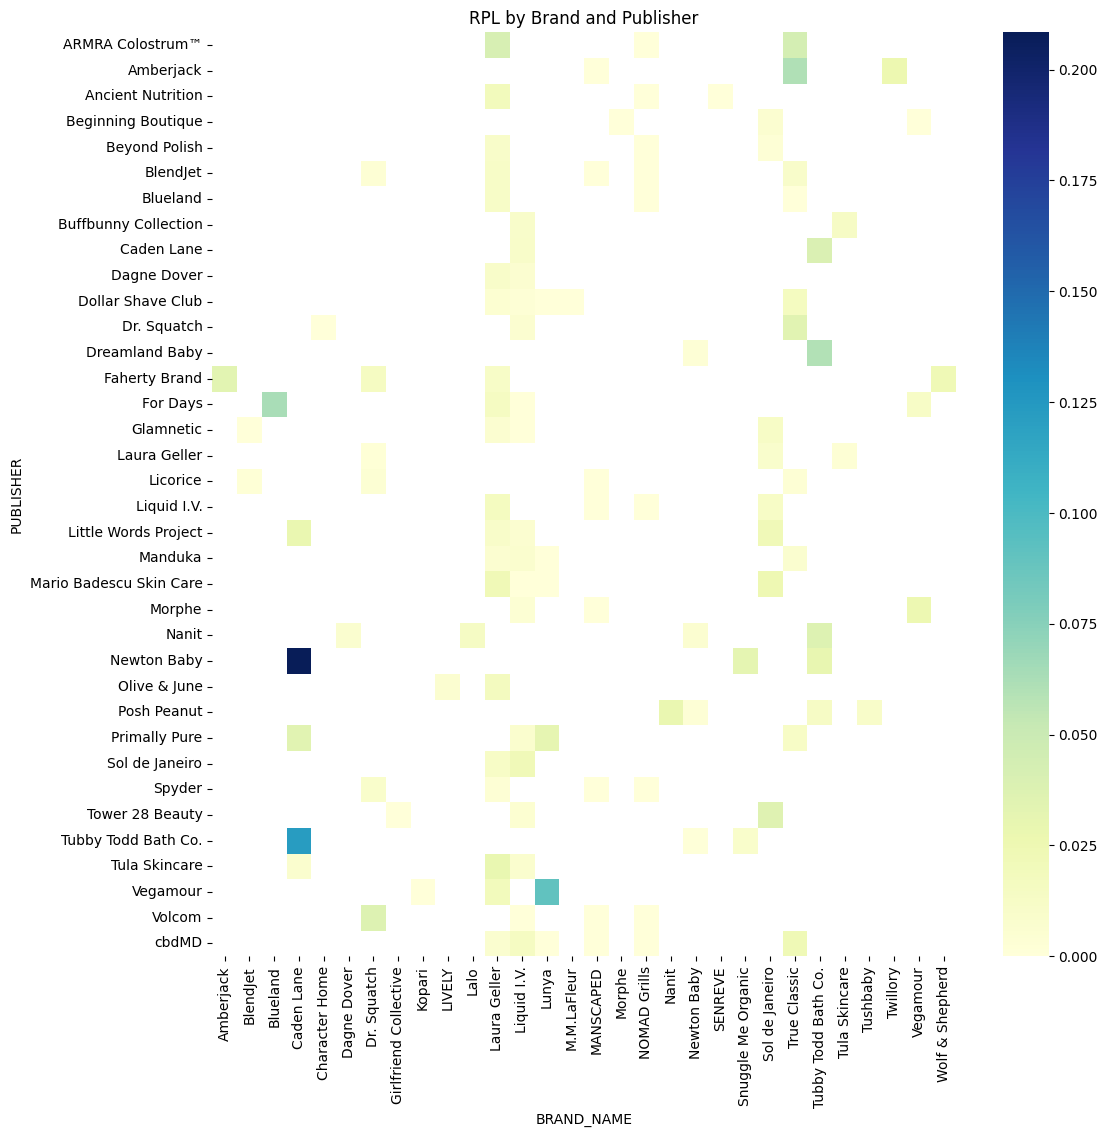

In [58]:
# Pivot the DataFrame to format suitable for heatmap
pivot_table = df_agg_filter.pivot_table(index="PUBLISHER", columns="BRAND_NAME", values="RPL", aggfunc="sum")

# Plotting the heatmap
plt.figure(figsize=(12, 12))
sns.heatmap(pivot_table, cmap="YlGnBu")
plt.title('RPL by Brand and Publisher')
plt.show()

In [104]:
df_agg_filter

,PUBLISHER,BRAND_NAME,TOTAL_AD_SPEND,BRAND_IMPRESSIONS,CONV_COUNT,RPL,RPL_rank_among_brands,average_RPL_rank
0,ARMRA Colostrum™,Laura Geller,375.0,9152,25,0.040975,1.0,4.00
1,ARMRA Colostrum™,NOMAD Grills,0.0,7490,0,0.000000,9.0,4.00
2,ARMRA Colostrum™,True Classic,225.0,5133,5,0.043834,2.0,4.00
3,Amberjack,MANSCAPED,0.0,4438,0,0.000000,8.0,3.33
4,Amberjack,True Classic,405.0,6681,9,0.060620,1.0,3.33
...,...,...,...,...,...,...,...,...
117,cbdMD,Liquid I.V.,35.0,2343,1,0.014938,2.0,7.50
118,cbdMD,Lunya,0.0,1944,0,0.000000,6.0,7.50
119,cbdMD,MANSCAPED,0.0,1978,0,0.000000,8.0,7.50
120,cbdMD,NOMAD Grills,0.0,4354,0,0.000000,9.0,7.50


#### Analytics of Brands

In [76]:
brand_pub_count = pd.DataFrame(df_agg_filter.groupby('BRAND_NAME').count()['PUBLISHER']).reset_index()
#Filter for brands that have at least 3 publishers
brand_pub_list = brand_pub_count[brand_pub_count['PUBLISHER'] >= 3].BRAND_NAME.tolist()
len(brand_pub_list)

12

In [77]:
#Filter the df_agg_filter dataframe to only include the rows where the brand_name is in the brand_pub_list
df_agg_filter2 = df_agg_filter[df_agg_filter['BRAND_NAME'].isin(brand_pub_list)]
print(df_agg_filter2.PUBLISHER.nunique())
print(df_agg_filter2.BRAND_NAME.nunique())

36
12


In [78]:
df_agg_filter2.sample(5)

,PUBLISHER,BRAND_NAME,TOTAL_AD_SPEND,BRAND_IMPRESSIONS,CONV_COUNT,RPL
110,Vegamour,Laura Geller,225.0,12001,15,0.018748
81,Newton Baby,Caden Lane,1964.0,9422,67,0.208448
18,BlendJet,NOMAD Grills,0.0,12349,0,0.000000
60,Liquid I.V.,NOMAD Grills,0.0,10843,0,0.000000
2,ARMRA Colostrum™,True Classic,225.0,5133,5,0.043834


In [99]:
def calculate_rpl_ranking(input_df):
    df = input_df.copy()
    
    # Step 1: Rank the RPL within each publisher for each brand
    df['RPL_rank_within_publisher'] = df.groupby('PUBLISHER')['RPL'].rank(method='max', ascending=False)

    # Step 2: Create a pivot table where each row is a brand, each column is a publisher, and the values are RPL ranks
    pivot_table = df.pivot_table(index='BRAND_NAME', columns='PUBLISHER', values='RPL_rank_within_publisher', aggfunc='first')

    # Step 3: Calculate the average rank of RPL for each brand across all publishers
    df['average_RPL_rank'] = round(df.groupby('BRAND_NAME')['RPL_rank_within_publisher'].transform('mean'),2)

    # Step 4: Reduce the dataframe to the columns of interest and drop duplicates
    result_df = df[['BRAND_NAME', 'average_RPL_rank']].drop_duplicates().set_index('BRAND_NAME')

    # Step 5: Add the list of ranks as a column
    result_df['list_of_ranks'] = pivot_table.apply(lambda x: x.dropna().astype(int).tolist(), axis=1)

    # Step 6: Add a column to show the number of publishers for each brand
    result_df['num_publishers'] = df.groupby('BRAND_NAME')['PUBLISHER'].nunique()

    # Step 7: Add a column to show the total impression count for each brand
    result_df['total_impressions'] = df.groupby('BRAND_NAME')['BRAND_IMPRESSIONS'].sum()

    return result_df.sort_values('average_RPL_rank', ascending=True).reset_index()  

brand_rpl_ranking = calculate_rpl_ranking(df_agg_filter2)

How does this look correlate with the brand's avg. placement order?

In [98]:
#Z-Score Normalization
def calculate_rpl_z_scores(input_df):
    df = input_df.copy()

    # Step 1: Calculate mean and std of RPL within each publisher
    df['mean_RPL'] = df.groupby('PUBLISHER')['RPL'].transform('mean')
    df['std_RPL'] = df.groupby('PUBLISHER')['RPL'].transform('std')

    # Step 2: Calculate the Z-score for each brand's RPL within each publisher
    df['RPL_z_score'] = round(df.apply(lambda x: (x['RPL'] - x['mean_RPL']) / x['std_RPL'] if x['std_RPL'] != 0 else 0, axis=1),3)

    # Step 3: Create a pivot table for Z-scores
    pivot_table = df.pivot_table(index='BRAND_NAME', columns='PUBLISHER', values='RPL_z_score', aggfunc='first')

    # Step 4: Calculate the average Z-score for each brand across all publishers
    df['avg_RPL_z_score'] = round(df.groupby('BRAND_NAME')['RPL_z_score'].transform('mean'),2)

    # Step 5: Reduce the dataframe to the columns of interest and drop duplicates
    result_df = df[['BRAND_NAME', 'avg_RPL_z_score']].drop_duplicates().set_index('BRAND_NAME')

    # Step 6: Add the list of Z-scores as a column
    result_df['list_of_z_scores'] = pivot_table.apply(lambda x: x.dropna().tolist(), axis=1)

    return result_df.sort_values('avg_RPL_z_score', ascending=False).reset_index()

brand_zscore = calculate_rpl_z_scores(df_agg_filter2)

In [101]:
#Merge the brand_rpl_ranking and brand_zscore dataframes
brand_perf = brand_rpl_ranking.merge(brand_zscore, on='BRAND_NAME')
brand_perf

,BRAND_NAME,average_RPL_rank,list_of_ranks,num_publishers,total_impressions,avg_RPL_z_score,list_of_z_scores
0,Tubby Todd Bath Co.,1.20,"[1, 1, 1, 2, 1]",5,41034,0.42,"[0.707, 0.707, 0.707, -0.707, 0.707]"
1,Sol de Janeiro,1.38,"[1, 2, 1, 1, 2, 2, 1, 1]",8,418215,0.61,"[0.707, -0.313, 1.026, 0.707, 0.603, 0.5, 0.95..."
2,Caden Lane,1.40,"[1, 1, 1, 1, 3]",5,144709,0.59,"[1.139, 0.707, 0.959, 0.707, -0.584]"
3,Dr. Squatch,1.50,"[3, 1, 2, 1, 1, 1]",6,260047,0.57,"[-0.285, 0.707, -0.707, 0.817, 1.358, 1.5]"
4,Vegamour,1.67,"[2, 2, 1]",3,21268,0.29,"[-0.707, 0.426, 1.138]"
5,Laura Geller,1.70,"[2, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 3, 3, 2, 1, ...",20,334772,0.35,"[0.518, 0.707, 1.119, 1.186, 1.155, 0.707, -0...."
6,True Classic,1.70,"[1, 1, 2, 3, 1, 1, 2, 2, 3, 1]",10,216962,0.56,"[0.635, 0.707, 0.922, -0.577, 1.436, 0.707, 0...."
7,Newton Baby,2.00,"[2, 2, 2, 2]",4,67469,-0.71,"[-0.707, -0.707, -0.707, -0.707]"
8,Liquid I.V.,2.47,"[1, 2, 2, 3, 2, 3, 3, 4, 1, 4, 2, 4, 1, 2, 2, ...",17,191907,-0.48,"[-0.707, -0.707, -0.421, -0.707, -1.143, -0.97..."
9,MANSCAPED,3.50,"[2, 5, 3, 3, 3, 4, 2, 6]",8,61035,-0.79,"[-0.707, -0.912, -1.115, -0.848, -0.737, -0.75..."


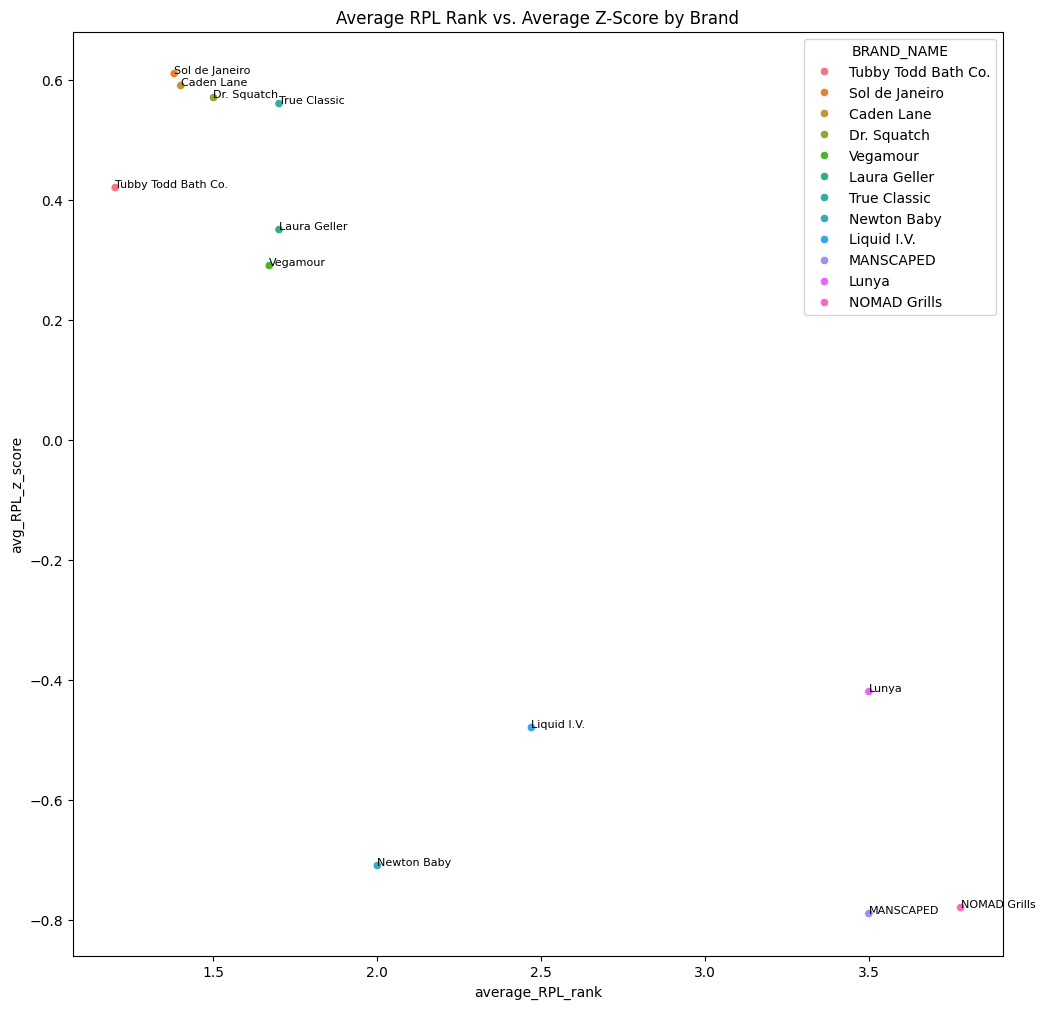

In [103]:
#Plot the average RPL rank and average Z-score for each brand in a scatter plot and label each point with the brand name
plt.figure(figsize=(12, 12))
sns.scatterplot(data=brand_perf, x='average_RPL_rank', y='avg_RPL_z_score', hue='BRAND_NAME')
for i in range(len(brand_perf)):
    plt.text(brand_perf['average_RPL_rank'][i], brand_perf['avg_RPL_z_score'][i], brand_perf['BRAND_NAME'][i], fontsize=8)
plt.title('Average RPL Rank vs. Average Z-Score by Brand')
plt.show()

#### Add analytics of publishers
this is likely less informative b/c of the relationship of publishers against brands *and* it does not take into account of avg. placement order within Discofeed?

In [92]:
def calculate_publisher_rpl_ranking(df):
    # Step 1: Rank the RPL for each brand within publishers
    df['RPL_rank_among_brands'] = df.groupby('BRAND_NAME')['RPL'].rank(method='max', ascending=False)

    # Step 2: Create a pivot table where each row is a publisher, each column is a brand, and the values are RPL ranks
    pivot_table = df.pivot_table(index='PUBLISHER', columns='BRAND_NAME', values='RPL_rank_among_brands', aggfunc='first')

    # Step 3: Calculate the average rank of RPL for each publisher across all brands
    df['average_RPL_rank'] = round(df.groupby('PUBLISHER')['RPL_rank_among_brands'].transform('mean'), 2)

    # Step 4: Reduce the dataframe to the columns of interest and drop duplicates
    result_df = df[['PUBLISHER', 'average_RPL_rank']].drop_duplicates().set_index('PUBLISHER')

    # Step 5: Add the list of ranks as a column
    result_df['list_of_ranks'] = pivot_table.apply(lambda x: x.dropna().astype(int).tolist(), axis=1)

    # Step 6: Add a column to show the number of brands for each publisher
    result_df['num_brands'] = df.groupby('PUBLISHER')['BRAND_NAME'].nunique()

    # Step 7: Add a column to show the total impressions for each publisher
    result_df['total_impressions'] = df.groupby('PUBLISHER')['BRAND_IMPRESSIONS'].sum()

    #Step 8: add total impressions for each publisher
    result_df['total_ad_spend'] = df.groupby('PUBLISHER')['TOTAL_AD_SPEND'].sum()

    return result_df.sort_values('average_RPL_rank', ascending=True).reset_index()

calculate_publisher_rpl_ranking(df_agg_filter)

,PUBLISHER,average_RPL_rank,list_of_ranks,num_brands,total_impressions,total_ad_spend
0,Nanit,1.50,"[1, 1, 1, 3]",4,19607,278.00
1,Newton Baby,2.00,"[1, 1, 4]",3,17434,2214.00
2,Dreamland Baby,2.00,"[3, 1]",2,22161,563.00
3,Posh Peanut,2.25,"[1, 2, 5, 1]",4,38179,556.00
4,Vegamour,2.33,"[1, 5, 1]",3,18937,525.00
5,Buffbunny Collection,2.50,"[4, 1]",2,17344,205.00
6,Caden Lane,2.50,"[3, 2]",2,20249,525.00
7,Tubby Todd Bath Co.,2.67,"[2, 4, 2]",3,201916,14116.00
8,Amberjack,3.33,"[8, 1, 1]",3,15608,525.00
9,Olive & June,3.50,"[1, 6]",2,42315,625.00
